### explore data
#### OER

### Prepare data for PyTorch

In [1]:
import torch
import torch.utils.data as td
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def loaddata(batchsize):
    x = np.load('./Data/datax-OER.npy')
    y = np.load('./Data/datay.npy')[:, 0]

    #split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=10)

    #create loader for training data and labels
    train_x = torch.Tensor(x_train).float()
    #train_x = train_x.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]).float()
    #print(train_x.shape)
    train_y = torch.Tensor(y_train).float()

    train_data = td.TensorDataset(train_x, train_y)
    train_loader = td.DataLoader(train_data,batch_size=batchsize, shuffle=False, num_workers=1)

    test_x = torch.Tensor(x_test).float()
    test_y = torch.Tensor(y_test).float()

    test_data = td.TensorDataset(test_x, test_y)
    test_loader = td.DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=1)

    return train_loader, test_loader

train_loader, test_loader = loaddata(1)
for datax, datay in train_loader:
    pass

print(datax.shape)
print(datay)

torch.Size([1, 8, 6])
tensor([4.7204])


### Build training model

In [13]:
#model0 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TopoCata(nn.Module):
    def __init__(self, feature_num):
        super(TopoCata, self).__init__()
        self.edge_index = torch.tensor(
            [
                [3, 0, 3, 1, 3, 2, 3, 7, 7, 4, 7, 5, 7, 6, 0, 1, 1, 6, 6, 4, 4, 5, 5, 2, 2, 0], 
                [0, 3, 1, 3, 2, 3, 7, 3, 4, 7, 5, 7, 6, 7, 1, 0, 6, 1, 4, 6, 5, 4, 2, 5, 0, 2]
            ],
            dtype=torch.long
            )

        self.gcnc_0 = GCNConv(feature_num, 64)
        self.gcnc_1 = GCNConv(64, 96)
        self.gcnc_2 = GCNConv(96, 128)
        
        self.regression = nn.Sequential(
            nn.Conv1d(128, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 32, 1),
            nn.ReLU(),
            nn.Conv1d(32, 1, 1),
            nn.AdaptiveMaxPool1d(1)
            )

    def forward(self, x):
        x = F.relu(self.gcnc_0(x, self.edge_index))
        x = F.relu(self.gcnc_1(x, self.edge_index))
        x = F.relu(self.gcnc_2(x, self.edge_index))
        x = x.transpose(1, 2)
        x = self.regression(x)
        x = x.squeeze(2)
        return x

inputs = torch.randn([1, 8, 11])
#print(inputs.shape[2])
model = TopoCata(inputs.shape[2])
print(model)

TopoCata(
  (gcnc_0): GCNConv(11, 64)
  (gcnc_1): GCNConv(64, 96)
  (gcnc_2): GCNConv(96, 128)
  (regression): Sequential(
    (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
    (5): AdaptiveMaxPool1d(output_size=1)
  )
)


In [2]:
#model 1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DACmetals(nn.Module):
    def __init__(self, feature_num):
        super(DACmetals, self).__init__()
        self.dnn0 = nn.Linear(feature_num, 64)
        self.dnn1 = nn.Linear(64, 128)
        self.dnn2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.dnn0(x))
        x = F.relu(self.dnn1(x))
        x = self.dnn2(x)
        return x

class substrates(nn.Module):
    def __init__(self, feature_num):
        super(substrates, self).__init__()
        self.conv0 = nn.Conv1d(feature_num, 64,3)
        self.conv1 = nn.Conv1d(64, 128, 3)
        self.conv2 = nn.Conv1d(128, 1, 2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x.squeeze(2)

class graphNN(nn.Module):
    def __init__(self, feature_num, device="cpu"):
        super(graphNN, self).__init__()
        self.edge_index = torch.tensor(
            [
                [3, 0, 3, 1, 3, 2, 3, 7, 7, 4, 7, 5, 7, 6, 0, 1, 1, 6, 6, 4, 4, 5, 5, 2, 2, 0], 
                [0, 3, 1, 3, 2, 3, 7, 3, 4, 7, 5, 7, 6, 7, 1, 0, 6, 1, 4, 6, 5, 4, 2, 5, 0, 2]
            ], dtype = torch.long
        )

        if device == "gpu":
            self.edge_index = self.edge_index.cuda()

        self.gcnc0 = GCNConv(feature_num, 64)
        self.gcnc1 = GCNConv(64, 96)
        self.gcnc2 = GCNConv(96, 128)

        self.conv1 = nn.Conv1d(128, 64, 1)
        self.conv2 = nn.Conv1d(64, 32, 1)
        self.conv3 = nn.Conv1d(32, 1, 1)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = F.relu(self.gcnc0(x, self.edge_index))
        x = F.relu(self.gcnc1(x, self.edge_index))
        x = F.relu(self.gcnc2(x, self.edge_index))

        x = x.transpose(1, 2)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pool(x)
        x = x.squeeze(2)
        return x


class TopoModel(nn.Module):
    def __init__(self, feature_num, device="cpu"):
        super(TopoModel, self).__init__()
        self.DAC_model = DACmetals(feature_num)
        self.substrate_model = substrates(feature_num)
        self.graph_model = graphNN(feature_num, device)
        self.model0 = nn.Linear(3, 64, 1)
        self.model1 = nn.Linear(64, 128, 1)
        self.model2 = nn.Linear(128, 1, 1)

    def forward(self, x):
        #DAC_out = self.DAC_model(x[:, [3, 7], :])
        DAC_out = self.DAC_model(x[:, 3, :] + x[:, 7, :])
        substrate_out = self.substrate_model(x[:, [0,1,2,4,5,6], :])
        #substrate_feature = self.substrate_feature(x[:, [0, 1, 2, 4, 5, 6], :])
        graph_out = self.graph_model(x)
        
        out = torch.cat([DAC_out, substrate_out, graph_out], dim=1)
        out = F.relu(self.model0(out))
        out = F.relu(self.model1(out))
        out = self.model2(out)
        return out

inputs = torch.randn([16, 8, 11]).float()
print(inputs.shape)

model = TopoModel(inputs.shape[2])
outputs = model(inputs)
print(model)


torch.Size([16, 8, 11])
TopoModel(
  (DAC_model): DACmetals(
    (dnn0): Linear(in_features=11, out_features=64, bias=True)
    (dnn1): Linear(in_features=64, out_features=128, bias=True)
    (dnn2): Linear(in_features=128, out_features=1, bias=True)
  )
  (substrate_model): substrates(
    (conv0): Conv1d(11, 64, kernel_size=(3,), stride=(1,))
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(128, 1, kernel_size=(2,), stride=(1,))
  )
  (graph_model): graphNN(
    (gcnc0): GCNConv(11, 64)
    (gcnc1): GCNConv(64, 96)
    (gcnc2): GCNConv(96, 128)
    (conv1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
    (pool): AdaptiveMaxPool1d(output_size=1)
  )
  (model0): Linear(in_features=3, out_features=64, bias=True)
  (model1): Linear(in_features=64, out_features=128, bias=True)
  (model2): Linear(in_features=128, out_features=1, bias=True)
)

### Train the model

In [3]:
def train(model, train_loader, optimizer):
    # set model to train mode
    model.train()
    train_loss, train_error = 0, 0

    index = 0
    for data, target in train_loader:
        #feed forward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        error = error_criteria(out, target)

        # backpropagate
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_error += error.item()
        index += 1

    avg_loss, avg_error = (train_loss / index), (train_error / index)
    print("training set: average loss: {}, error: {}".format(avg_loss, avg_error))
    return avg_loss, avg_error


def test(model, test_loader):
    # set model to test mode
    model.eval()
    test_loss, test_error = 0, 0
    
    with torch.no_grad():
        index = 0
        for data, target in test_loader:
            out = model(data)
            loss = loss_criteria(out, target)
            error = error_criteria(out, target)

            test_loss += loss.item()
            test_error += error.item()
            index += 1
            
        avg_loss, avg_error = (test_loss/index), (test_error/index)
        print("test set: average loss: {}, error:{}".format(avg_loss, avg_error))
        return avg_loss, avg_error

#### Train the model

In [4]:
import torch.nn as nn

# specify the loss criteria
class MyError(nn.Module):
    def __init__(self):
        super(MyError, self).__init__()
    def forward(self, pred, real):
        return torch.mean(torch.abs(torch.sub(pred,real)/real))

# load model
feature_num = 6
model = TopoModel(feature_num)

# error and loss
error_criteria = MyError()
loss_criteria = nn.MSELoss(reduction="mean")

# load data
batchsize = 1
train_loader, test_loader = loaddata(batchsize)

# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
optimizer.zero_grad()

# track the training
epoch_nums = []
training_loss, training_error = [], []
testing_loss, testing_error = [], []

epoch = 150 
for epoch in range(1, epoch+1):
    print("Epoch: {}".format(epoch))
    train_loss, train_error = train(model, train_loader, optimizer)
    test_loss, test_error = test(model, test_loader)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_error.append(train_error)
    
    testing_loss.append(test_loss)
    testing_error.append(test_error)



Epoch: 1


C:\Users\lpwu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training set: average loss: 1.8297686071656472, error: 0.3404099311475875
test set: average loss: 0.9031255699487196, error:0.29446117993858123
Epoch: 2
training set: average loss: 1.3629415911460683, error: 0.2932328197042807
test set: average loss: 0.8689306639134884, error:0.28198732746144134
Epoch: 3
training set: average loss: 1.2814523078748608, error: 0.278223946171056
test set: average loss: 0.7884322812726402, error:0.24686866658319356
Epoch: 4
training set: average loss: 1.1722638812422133, error: 0.26406726767891087
test set: average loss: 0.7930763879857194, error:0.2572686999208397
Epoch: 5
training set: average loss: 1.1342987859031752, error: 0.2546244431858213
test set: average loss: 0.8888855291394672, error:0.28261719250844586
Epoch: 6
training set: average loss: 1.1014556434563303, error: 0.2500961258185271
test set: average loss: 0.8574563290102459, error:0.27553595413660836
Epoch: 7
training set: average loss: 1.0584379445286687, error: 0.24486941812647273
test set

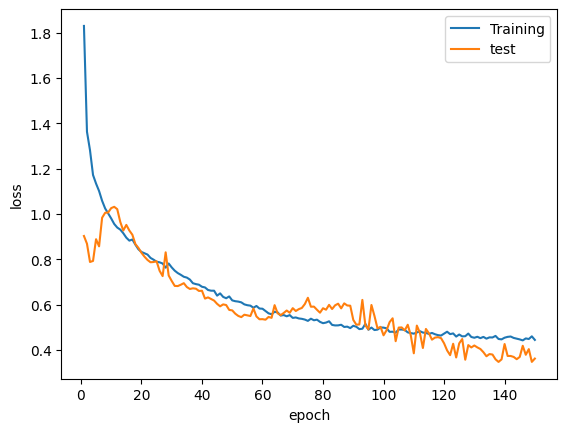

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'test'], loc='upper right')
plt.show()



In [15]:
plt.savefig("./Models/OER_loss.png")

<Figure size 640x480 with 0 Axes>

#### save the trained model

In [6]:
model_file = "./Models/DAC_OER.pt"
torch.save(model.state_dict(), model_file)
del model
print("model is saved")

model is saved
